In [89]:
import time
import random
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib.pyplot as ptr
import matplotlib as mpl
import enum
import math
from scipy.integrate import odeint
from scipy.stats import pearsonr, spearmanr, poisson
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import networkx as nx
import seaborn as sns
from multiprocessing import Pool

steps_per_day = 30
viral_load_max = 50000

p_trans_div = viral_load_max * steps_per_day


class InfectionMultiscaleModel(Model):
    """A model for infection spread."""

    def __init__(self, N=10, steps_per_day = 2,
                 v_threshold=300000, G='constant', F='linear',
                 con_init=5, lin_init=1, log_init=1, ind_init=5,
                 sig_init=1, delay=0, output_tree=None):

        self.num_agents = N
        self.steps_per_day = steps_per_day
        self.con_init = con_init
        self.lin_init = lin_init
        self.log_init = log_init
        self.sig_init = sig_init
        self.ind_init = ind_init
        self.delay = delay
        self.schedule = RandomActivation(self)
        self.running = True
        self.dead_agents = []
        self.G = G
        self.F = F
        self.r0 = 0
        self.ptrans = 1.0 / steps_per_day
        self.viral_load_max = viral_load_max
        self.inoc_max = 50000
        self.inoc_max_sig = np.power(self.inoc_max/2,self.sig_init)
        self.infected = 0
        self.removed = 0
        self.viral_load_tree = dict()

        self.sig_infector_multiplier = self.lin_init * self.inoc_max
        self.sig_ptrans_multiplier = self.inoc_max / p_trans_div

        self.con_ptrans_multiplier = self.sig_ptrans_multiplier / 2

        if G == 'constant':
            # self.v_threshold = 1 / self.lin_init
            self.v_threshold = 5000
        elif G == 'random':
            # self.v_threshold = 1 / self.lin_init
            self.v_threshold = 5000
        elif G == 'linear':
            # self.v_threshold = 1 / self.lin_init
            self.v_threshold = 5000
        elif G == 'log':
            self.v_threshold = np.exp(1 / (self.log_init * self.inoc_max))
        elif G == 'sigmoid':
            beta = self.lin_init * self.inoc_max
            self.v_threshold = np.power(self.inoc_max_sig/(beta * (1 - (1/beta))),1/self.sig_init) - self.delay
            # self.v_threshold = 5000
        
        print(self.lin_init,self.sig_init,self.v_threshold)

        # Create agents
        for i in range(self.num_agents):
            a = MSMyAgent(i, self)
            self.schedule.add(a)
            if i == 1:
                a.state = MSState.INFECTED
                a.infection_course = a.infect_stein_init('constant',a.unique_id,self.ind_init,1)

        self.datacollector = DataCollector(
            model_reporters={"r0" : "r0",
                            "viral_load_tree" : "viral_load_tree"},
            agent_reporters={"State": "state"})

    def step(self):
        self.datacollector.collect(self)
        self.viral_load_tree = dict()
        self.schedule.step()

        

class MSState(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 2

def differential_stein(n_stein, t, r,kI,kN,kP,aI,aN,aP,bI,dN,c,kV,KI,tN,tP):
    dV_dt = r*n_stein[0] - n_stein[0]*(((r*n_stein[0])/kV) + kI*n_stein[1] + kN*n_stein[2] + kP*n_stein[3])
    dI_dt = aI*n_stein[0] + bI*(1-(n_stein[1]/KI))
    dN_dt = aN*n_stein[0]*np.heaviside(t-tN,1)-dN*n_stein[2]
    dP_dt = aP*n_stein[0]*n_stein[3] + c*n_stein[2]*(t-tP)
    return dV_dt, dI_dt, dN_dt, dP_dt
    
class MSMyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)      
        self.state = MSState.SUSCEPTIBLE  
        self.infection_time = 0
        self.infection_course = []
        self.init_v = 0
    
    def infect_stein(self, G, donor_id, donor, donor_init_v):
        t = np.linspace(0, 24, num=24 * self.model.steps_per_day)
        y0 = ()
        r = 5.5
        kI = 0.05
        kN = 0.5
        kP = 2
        aI = 0.000000001
        aN = 0.00000001
        aP = 0.000005
        bI = 2
        dN = 0.05
        c = 0.01
        kV = 100000000000
        KI = 100
        tN = 2.5
        tP = 3
        n0 = 0
        p0 = 2
        
        if G == 'constant':
            init_v = self.model.con_init
        elif G == 'random':
            init_v = self.random.randint(1,499)
        elif G == 'bottleneck':
            init_v = np.minimum(1, donor * 0.000001)
        elif G == 'linear':
            # init_v = self.model.lin_init * donor
            foo = self.model.lin_init * donor
            init_v = np.mean(poisson.rvs(foo, size=100))
        elif G == 'log':
            init_v = self.model.log_init * np.log(donor)
        elif G == 'sigmoid':
            # init_v = self.model.lin_init * self.model.inoc_max * np.power(donor + self.model.delay,self.model.sig_init) / (np.power(donor + self.model.delay,self.model.sig_init) + self.model.inoc_max_sig)
            foo = self.model.sig_infector_multiplier * np.power(donor + self.model.delay,self.model.sig_init) / (np.power(donor + self.model.delay,self.model.sig_init) + self.model.inoc_max_sig)
            init_v = np.mean(poisson.rvs(foo, size=100))

        # if init_v < 1:
        #     print('V0 less than 1 found')
        #     init_v = 1

        self.init_v = init_v
            
        y0 = (init_v, 0, n0, p0)
        
        solution = odeint(differential_stein, y0, t, args=(r,kI,kN,kP,aI,aN,aP,bI,dN,c,kV,KI,tN,tP))
        solution = [[row[i] for row in solution] for i in range(4)]

        exp_time = get_exposed_period(solution[0],self.model.v_threshold)

        self.model.infected += 1
        self.model.viral_load_tree[(donor_id,self.unique_id)] = (donor_init_v,init_v,donor,self.infection_time, exp_time)

        return solution

    def infect_stein_init(self, G, donor_id, donor, donor_init_v):
        t = np.linspace(0, 24, num=24 * self.model.steps_per_day)
        y0 = ()
        r = 5.5
        kI = 0.05
        kN = 0.5
        kP = 2
        aI = 0.000000001
        aN = 0.00000001
        aP = 0.000005
        bI = 2
        dN = 0.05
        c = 0.01
        kV = 100000000000
        KI = 100
        tN = 2.5
        tP = 3
        n0 = 0
        p0 = 2
        
        if G == 'constant':
            init_v = self.model.ind_init
        elif G == 'random':
            init_v = self.random.randint(1,3000000)
        elif G == 'bottleneck':
            init_v = np.minimum(1, donor * 0.000001)
        elif G == 'linear':
            init_v = self.model.lin_init * donor
        elif G == 'log':
            init_v = self.model.log_init * np.log(donor)
        elif G == 'sigmoid':
            init_v = self.model.sig_infector_multiplier * np.power(donor + self.model.delay,self.model.sig_init) / (np.power(donor + self.model.delay,self.model.sig_init) + self.model.inoc_max_sig)

        self.model.infected += 1
        # self.model.viral_load_tree[(donor_id,self.unique_id)] = (donor_init_v,init_v,donor)

        self.init_v = init_v
            
        y0 = (init_v, 0, n0, p0)
        
        solution = odeint(differential_stein, y0, t, args=(r,kI,kN,kP,aI,aN,aP,bI,dN,c,kV,KI,tN,tP))
        solution = [[row[i] for row in solution] for i in range(4)]

        return solution

    def status(self):
        """Check infection status"""

        if self.state == MSState.INFECTED: 
            t = self.model.schedule.time-self.infection_time
            # if self.infection_course[0][t] < 1:
            if self.infection_course[0][t] < 1:
                self.state = MSState.REMOVED
                self.model.infected -= 1
                self.model.removed += 1


    def contact(self):
        """Find close contacts and infect"""
        
        if self.state is MSState.INFECTED:
            cellmates = self.random.sample(self.model.schedule.agents,k=1)
            t = self.model.schedule.time-self.infection_time
            if t>0:
                var_ptrans = self.get_ptrans(self.infection_course[0][t], self.model.F)
                for other in cellmates:
                    # if other.state is MSState.SUSCEPTIBLE and self.infection_course[0][t] > self.model.v_threshold and self.random.random() < var_ptrans:                 
                    if other.state is MSState.SUSCEPTIBLE and self.random.random() < var_ptrans:                 
                        other.state = MSState.INFECTED
                        other.infection_time = self.model.schedule.time
                        other.infection_course = other.infect_stein(model.G,self.unique_id,self.infection_course[0][t],self.init_v)
                        if self.unique_id == 1:
                            self.model.r0 += 1
                        # print(self.init_v,var_ptrans,self.infection_course[0][t],other.init_v)
                    
    def step(self):
        self.status()
        self.contact()


    def get_ptrans(self,V,F):
        if V < self.model.v_threshold:
            return 0
        if F == 'linear':
            return V / p_trans_div
        if F == 'sigmoid':
            return self.model.sig_ptrans_multiplier * np.power(V,self.model.sig_init) / (np.power(V,self.model.sig_init) + np.power(self.model.inoc_max/2,self.model.sig_init))
        if F == 'random':
            return self.random.random() * self.model.sig_ptrans_multiplier
        if F == 'constant':
            return self.model.con_ptrans_multiplier
        

def get_column_data(model):
    """pivot the model dataframe to get states count at each step"""
    agent_state = model.datacollector.get_agent_vars_dataframe()
    model_state = model.datacollector.get_model_vars_dataframe()

    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    X['r0'] = model_state['r0']
    X['viral_load_tree'] = model_state['viral_load_tree']

    labels = ['Susceptible','Infected','Removed','R0','Viral Load Tree']
    X.columns = labels[:len(X.columns)]
    X['Incidence'] = X['Susceptible'].diff() * -1
    X['Recovery'] = X['Removed'].diff()


    for j in range(X.shape[0],steps):
        X.loc[j] = 0
        X['Viral Load Tree'].loc[j] = []
    X['Days'] = X.index
    X['Days'] = X['Days'].div(steps_per_day)


    X['Incidence Sum'] = X['Incidence']
    X['Incidence Days'] = 0

    for i in range(0,days):
        X['Incidence Sum'].loc[i] = X['Incidence'][i*steps_per_day:(i+1)*steps_per_day].sum()
        X['Incidence Days'].loc[i] = i
    return X

def get_exposed_period(V, threshold):
    for i in range(len(V)):
        if V[i] > threshold:
            return i

    return None

def get_all_lengths_gen(G,root):

    paths = []

    for node in G:
        if G.out_degree(node)==0:
            paths.append(nx.shortest_path_length(G, source=root, target=node))
    
    return paths

def get_avg_length_gen(G,root):
    paths = []

    for node in G:
        if G.out_degree(node)==0:
            paths.append(nx.shortest_path_length(G, source=root, target=node))

    return np.mean(paths)

def get_all_lengths_time(G,root):
    paths = []

    for node in G:
        if G.out_degree(node)==0:
            paths.append((G.nodes[node]['time'] - G.nodes[root]['time']) / steps_per_day)

    return paths

def get_avg_length_time(G,root,tree):
    paths = []

    for node in G:
        if G.out_degree(node)==0:
            paths.append((tree.nodes[node]['time'] - tree.nodes[root]['time']) / steps_per_day)

    return np.mean(paths)



days = 300
steps = steps_per_day * days
pop = 10000

ptr.close("all")

data_whole = pd.DataFrame()

# SUBTREE ANALYSIS

# ptrans_funcs = ['constant', 'sigmoid', 'linear', 'random']
ptrans_funcs = ['constant']
Dv_Rv_funcs = ['constant',  'sigmoid', 'linear', 'random']
# Dv_Rv_funcs = ['random']

z = [[a, b, 450] for b in ptrans_funcs for a in Dv_Rv_funcs]

results_df = []

print(z)

no_sims = 1

ptr.figure(figsize=(10,10), dpi=100)

for j, f, init in z:

    data_whole = pd.DataFrame()
    r0s_inner = []
    for i in range(no_sims):
        print("Sim: " + str(i))
        while(True):
            model = InfectionMultiscaleModel(pop, steps_per_day=steps_per_day, v_threshold=10000, G=j, ind_init=init, con_init=250, sig_init=10, delay=0, lin_init=0.01, log_init=400, F=f)
            for i in range(steps):
                model.step()
                if model.infected == 0:
                    model.step()
                    break
            if model.r0 != 0 and model.removed > 1000:
                break

        data = get_column_data(model)
        if i==0:
            data_whole = data
        else:
            data_whole = data_whole.append(data)

        print(max(data_whole['Removed']))
        
    results_df.append(data_whole)

[['constant', 'constant', 450], ['sigmoid', 'constant', 450], ['linear', 'constant', 450], ['random', 'constant', 450]]
Sim: 0
0.01 10 5000
8669
Sim: 0
0.01 10 13431.668173494038
0.01 10 13431.668173494038
2890
Sim: 0
0.01 10 5000
8653
Sim: 0
0.01 10 5000
8709


<Figure size 1000x1000 with 0 Axes>

In [32]:
results_sig = results_df

In [34]:
results_lin = results_df

In [87]:
results_rand = results_df

In [90]:
results_const = results_df

In [112]:
results_sig = []
results_sig.append([2].to_csv('linear_constant.csv')

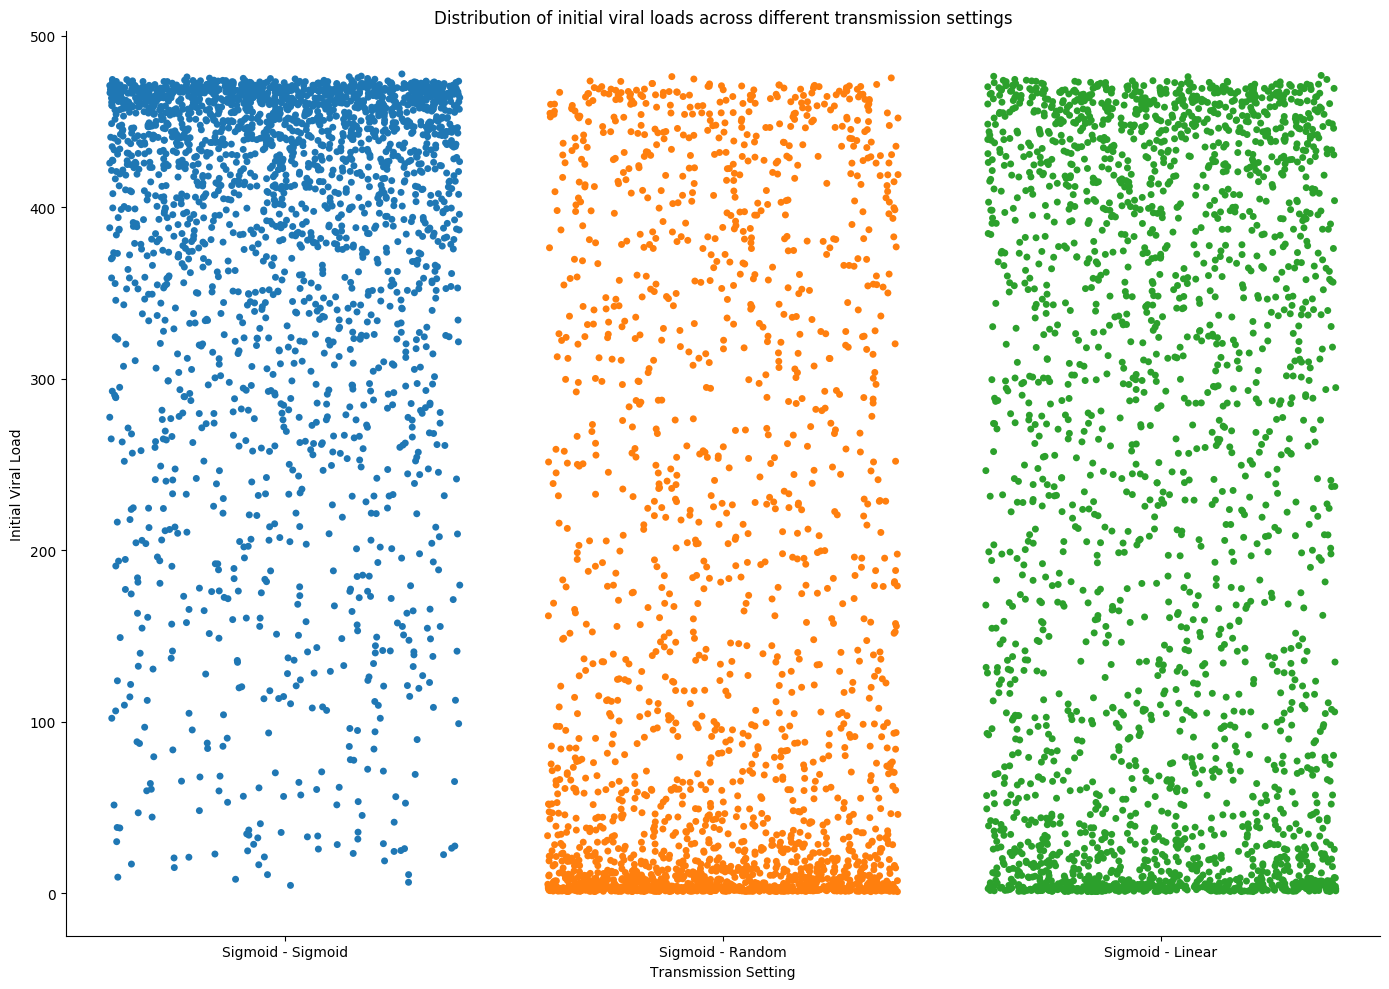

In [149]:
dists = []

dists.append(results_sig[1]['Viral Load Tree'])
dists.append(results_rand[1]['Viral Load Tree'])
dists.append(results_lin[1]['Viral Load Tree'])


for dist in range(len(dists)):
    dists[dist] = dists[dist][dists[dist].astype(bool)]
    dists[dist] = [list(k.values())[0][1] for k in dists[dist]]


ptr.figure(figsize=(14,10), dpi=100)

axes_a = ptr.subplot(111, title='Distribution of initial viral loads across different transmission settings')
axes_a.set_ylabel("Initial Viral Load")
axes_a.set(xlabel="Transmission Setting")

labs_settings = ['Sigmoid - Sigmoid','Sigmoid - Random', 'Sigmoid - Linear']

sns.stripplot(data=[dist for dist in dists], ax=axes_a, jitter=0.4)
sns.despine()

axes_a.set_xticklabels(labs_settings)

ptr.tight_layout()

ptr.savefig(fname='size_sp_' + j + '_' + f)
ptr.show()

ptr.close("all")

In [1]:
dists = []

dists.append(results_sig[3]['Viral Load Tree'])
dists.append(results_sig[2]['Viral Load Tree'])


for dist in range(len(dists)):
    dists[dist] = dists[dist][dists[dist].astype(bool)]
    dists[dist] = [list(k.values())[0][1] for k in dists[dist]]


ptr.figure(figsize=(14,10), dpi=100)

axes_a = ptr.subplot(111, title='Distribution of initial viral loads across different transmission settings')
axes_a.set_ylabel("Initial Viral Load")
axes_a.set(xlabel="Transmission Setting")

labs_settings = ['Random - Sigmoid','Linear - Sigmoid']

sns.stripplot(data=[dist for dist in dists], ax=axes_a, jitter=0.4)
sns.despine()

axes_a.set_xticklabels(labs_settings)

ptr.tight_layout()

ptr.savefig(fname='size_sp_' + j + '_' + f)
ptr.show()

ptr.close("all")

NameError: name 'results_sig' is not defined

In [211]:
dists = [results_sig[1]['Viral Load Tree']]


for dist in range(len(dists)):
    dists[dist] = dists[dist][dists[dist].astype(bool)]
    dists[dist] = [list(k.values())[0][1] for k in dists[dist]]
    
print(dists[0])

[473.36, 471.27, 258.58, 372.63, 450.46, 426.55, 436.51, 141.1, 456.09, 457.94, 458.62, 466.17, 400.91, 447.95, 194.59, 471.09, 454.59, 411.9, 473.33, 203.47, 470.05, 416.49, 473.96, 456.0, 394.65, 463.11, 424.43, 395.72, 466.77, 464.16, 457.15, 247.03, 461.07, 345.84, 393.27, 464.79, 472.31, 472.28, 433.39, 457.16, 460.91, 431.55, 470.65, 445.09, 471.45, 426.61, 377.92, 462.8, 391.97, 470.79, 470.55, 400.85, 464.4, 359.46, 462.1, 471.8, 454.68, 454.11, 466.67, 461.1, 375.54, 324.39, 95.18, 31.54, 440.84, 135.69, 185.43, 421.65, 464.7, 444.47, 431.31, 466.97, 459.26, 434.46, 396.73, 463.38, 430.51, 311.64, 85.65, 443.16, 448.82, 469.82, 407.16, 404.9, 386.37, 468.85, 455.29, 285.49, 446.91, 399.11, 468.52, 455.14, 426.48, 410.38, 321.48, 462.76, 467.75, 439.83, 472.19, 465.95, 471.3, 263.9, 247.33, 467.59, 437.56, 417.55, 463.4, 466.07, 449.18, 192.8, 335.48, 209.45, 468.64, 427.79, 436.74, 446.24, 399.56, 429.32, 431.99, 471.15, 445.75, 459.74, 163.25, 164.62, 406.07, 470.63, 449.08, 

In [194]:
#SIG - CONST
# data_whole = results_sig[0]

#SIG - SIG
# data_whole = results_sig[1]

#SIG - LIN
# data_whole = results_sig[2]

#SIG - RAND
# data_whole = results_sig[3]


#LIN - CONST
# data_whole = results_lin[0]

#LIN - SIG
# data_whole = results_lin[1]

#LIN - LIN
data_whole = results_lin[2]

#LIN - RAND
# data_whole = results_lin[3]


#CONST - CONST
# data_whole = results_const[0]

#CONST - SIG
# data_whole = results_const[1]

#CONST - LIN
# data_whole = results_const[2]

#CONST - RAND
# data_whole = results_const[3]


#RAND - CONST
# data_whole = results_rand[0]

#RAND - SIG
# data_whole = results_rand[1]

#RAND - LIN
# data_whole = results_rand[2]

#RAND - RAND
# data_whole = results_rand[3]

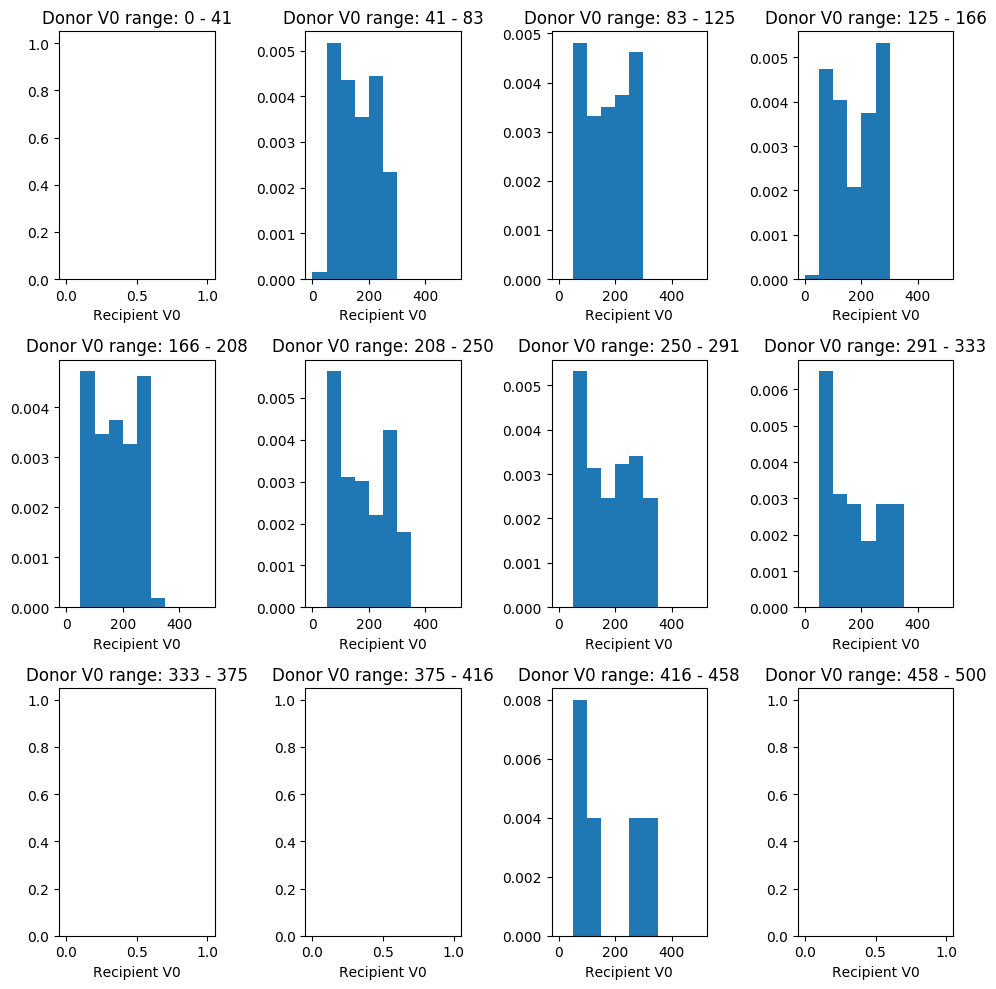

In [148]:
ptr.close('all')

ptr.figure(figsize=(10,10), dpi=100)

data_hist = data_whole['Viral Load Tree']
data_hist = data_hist[data_hist.astype(bool)]

length = 4
width = 4

size = length * width

v_max = 500
j_add = v_max / size
i_add = width * j_add

for i in range(4):
    for h in range(4):
        lower = i_add*i + j_add*h
        upper = i_add*i + j_add*(h+1)

        vals = [(list(k.values())[0][0],list(k.values())[0][1]) for k in data_hist if (list(k.values())[0][0] > lower) & (list(k.values())[0][0] <= upper)]

        dons = [i[0] for i in vals]
        recs = [i[1] for i in vals]

        ax = ptr.subplot2grid((4,4), (i,h), title='Donor V0 range: ' + str(int(lower)) + ' - ' + str(int(upper)), xlabel='Recipient V0')
        ax.hist(recs,bins=10,range=(0,500), density=True)
        
ptr.tight_layout()

ptr.savefig(fname='hist_' + j + '_' + f)
ptr.show()

ptr.close("all")

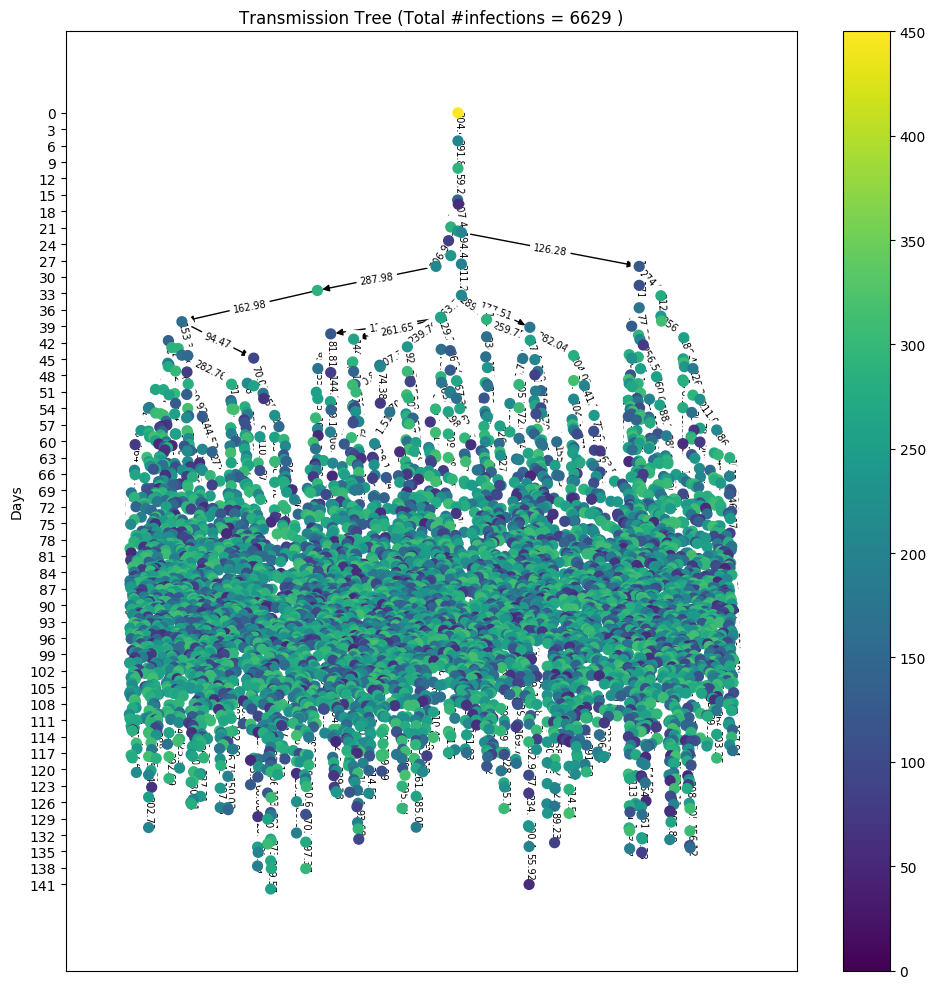

In [195]:
ptr.figure(figsize=(10,10), dpi=100)

ax = plt.subplot(111)
tree = nx.DiGraph()
ax.set_title('Transmission Tree (Total #infections = ' + str(max(data_whole['Removed'])) + ' )')
ax.set_xticks([])

for i, row in data_whole.iterrows():
    if not len(row['Viral Load Tree']) == 0:
        for i in row['Viral Load Tree']:
            if tree.number_of_nodes() < 10000:
                if tree.has_node(i[0]):
                    tree.add_node(i[1], init_v=round(row['Viral Load Tree'][i][1],2), time=round(row['Viral Load Tree'][i][3],2), 
                        gen=tree.nodes[i[0]]['gen'] + 1, exp=row['Viral Load Tree'][i][4])
                    tree.add_edge(i[0],i[1], rec_init=round(row['Viral Load Tree'][i][1],2))
                else:
                    tree.add_node(i[0], init_v=round(row['Viral Load Tree'][i][0],2), time=0, gen=0, exp=None)
                    tree.add_node(i[1], init_v=round(row['Viral Load Tree'][i][1],2), time=round(row['Viral Load Tree'][i][3],2), 
                        gen=tree.nodes[i[0]]['gen'] + 1, exp=row['Viral Load Tree'][i][4])
                    tree.add_edge(i[0],i[1],rec_init=round(row['Viral Load Tree'][i][1],2)) 

pos=nx.drawing.nx_agraph.graphviz_layout(tree, prog='dot')
max_time = max([tree.nodes[i]['time'] for i in tree.nodes()])
max_gen = max([tree.nodes[i]['gen'] for i in tree.nodes()])

for node in tree.nodes():
    pos[node] = (pos[node][0],-1*tree.nodes[node]['time'])

nodes = nx.draw_networkx_nodes(tree, ax=ax, pos=pos, node_size=50,
                node_color=list(nx.get_node_attributes(tree, 'init_v').values()),
                cmap=ptr.cm.viridis, vmin=0)
edges = nx.draw_networkx_edges(tree, ax=ax, pos=pos, node_size=50)
edge_labels_dict = nx.get_edge_attributes(tree,'rec_init')
edge_labels = nx.draw_networkx_edge_labels(tree, ax=ax, pos=pos, font_size=7, edge_labels=edge_labels_dict)

ptr.colorbar(nodes)

yticks = range(0,-1*max_time,(-3 * steps_per_day))
labelsy = [ round(-1*i/steps_per_day) for i in yticks]

ax.set_yticks(yticks)
ax.set_yticklabels(labelsy)

ax.set_ylabel('Days')



ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

ptr.tight_layout()

ptr.savefig(fname='trans_tree_' + j + '_' + f)
ptr.show()

In [196]:
init_vs = []
init_vs_parents = []
times = []
generations = []
exps = []
sizes = []
lengths = []
sec_cases = []
GFs = []
SLs = []
GIs = []

binned_init_vs = []
bins_vs = np.linspace(0,500,num=21)
for g in bins_vs:
    binned_init_vs.append([])

binned_time = []
bins_time = np.linspace(0,days,num=21)
for g in bins_time:
    binned_time.append([])

binned_gen = []
# bins_gen = list(range(0,max_gen+3,2))
bins_gen = list(range(0,51,2))
# print(max_gen,bins_gen)
for g in bins_gen:
    binned_gen.append([])


for node in tree.nodes():
    # if tree.nodes[node]['time'] > 10*steps_per_day and tree.nodes[node]['time'] < 55*steps_per_day:
    sub = nx.dfs_tree(tree,node)
    children = list(tree.successors(node))
    GI = []
    exp = None
    # if children:
    #     parent = parent[0]
    # else:
    #     parent = None

    bin_no_vs = np.digitize(tree.nodes[node]['init_v'],bins_vs)
    # if bin_no_vs >= len(bins_vs):
    #     print(tree.nodes[node]['init_v'], bin_no_vs, len(bins_vs))
    bin_no_time = np.digitize(tree.nodes[node]['time']/steps_per_day,bins_time)
    bin_no_gen = np.digitize(tree.nodes[node]['gen'],bins_gen)

    # raw data sets
    init_vs.append(tree.nodes[node]['init_v'])
    times.append(tree.nodes[node]['time']/steps_per_day)
    generations.append(tree.nodes[node]['gen'])
    if tree.nodes[node]['exp']:
        exp = tree.nodes[node]['exp']/steps_per_day
        exps.append(tree.nodes[node]['exp']/steps_per_day)

    sizes.append(sub.size())
    lengths.append(get_avg_length_gen(sub,node))
    sec_cases.append(len(list(tree.successors(node))))
    GFs.append(np.mean([tree.nodes[i]['init_v'] for i in tree.successors(node)]) / tree.nodes[node]['init_v'])
    SLs.append(sub.size() / get_avg_length_gen(sub,node))
    if children:
        for i in children:
            GIs.append((tree.nodes[i]['time'] - tree.nodes[node]['time']) / steps_per_day)
            init_vs_parents.append(tree.nodes[node]['init_v'])



    #binned data sets
    binned_init_vs[bin_no_vs].append([sub.size(),get_avg_length_gen(sub,node),len(list(tree.successors(node))),np.mean([tree.nodes[i]['init_v'] for i in tree.successors(node)]) / tree.nodes[node]['init_v'], 
        sub.size() / get_avg_length_gen(sub,node), get_avg_length_time(sub,node,tree), exp, GI])
    binned_time[bin_no_time].append([sub.size(),get_avg_length_gen(sub,node),len(list(tree.successors(node))),np.mean([tree.nodes[i]['init_v'] for i in tree.successors(node)]) / tree.nodes[node]['init_v'], 
        sub.size() / get_avg_length_gen(sub,node), get_avg_length_time(sub,node,tree), exp, GI])
    if bin_no_gen < len(binned_gen):
        binned_gen[bin_no_gen].append([sub.size(),get_avg_length_gen(sub,node),len(list(tree.successors(node))),np.mean([tree.nodes[i]['init_v'] for i in tree.successors(node)]) / tree.nodes[node]['init_v'], 
        sub.size() / get_avg_length_gen(sub,node), get_avg_length_time(sub,node,tree), exp, GI])


ptr.close("all")

nan_fil_inits = [[x[4] for x in y if not np.isnan(x[4])] for y in binned_init_vs[1:]]
nan_fil_time = [[x[4] for x in y if not np.isnan(x[4])] for y in binned_time[1:]]
nan_fil_gen = [[x[4] for x in y if not np.isnan(x[4])] for y in binned_gen[1:]]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars


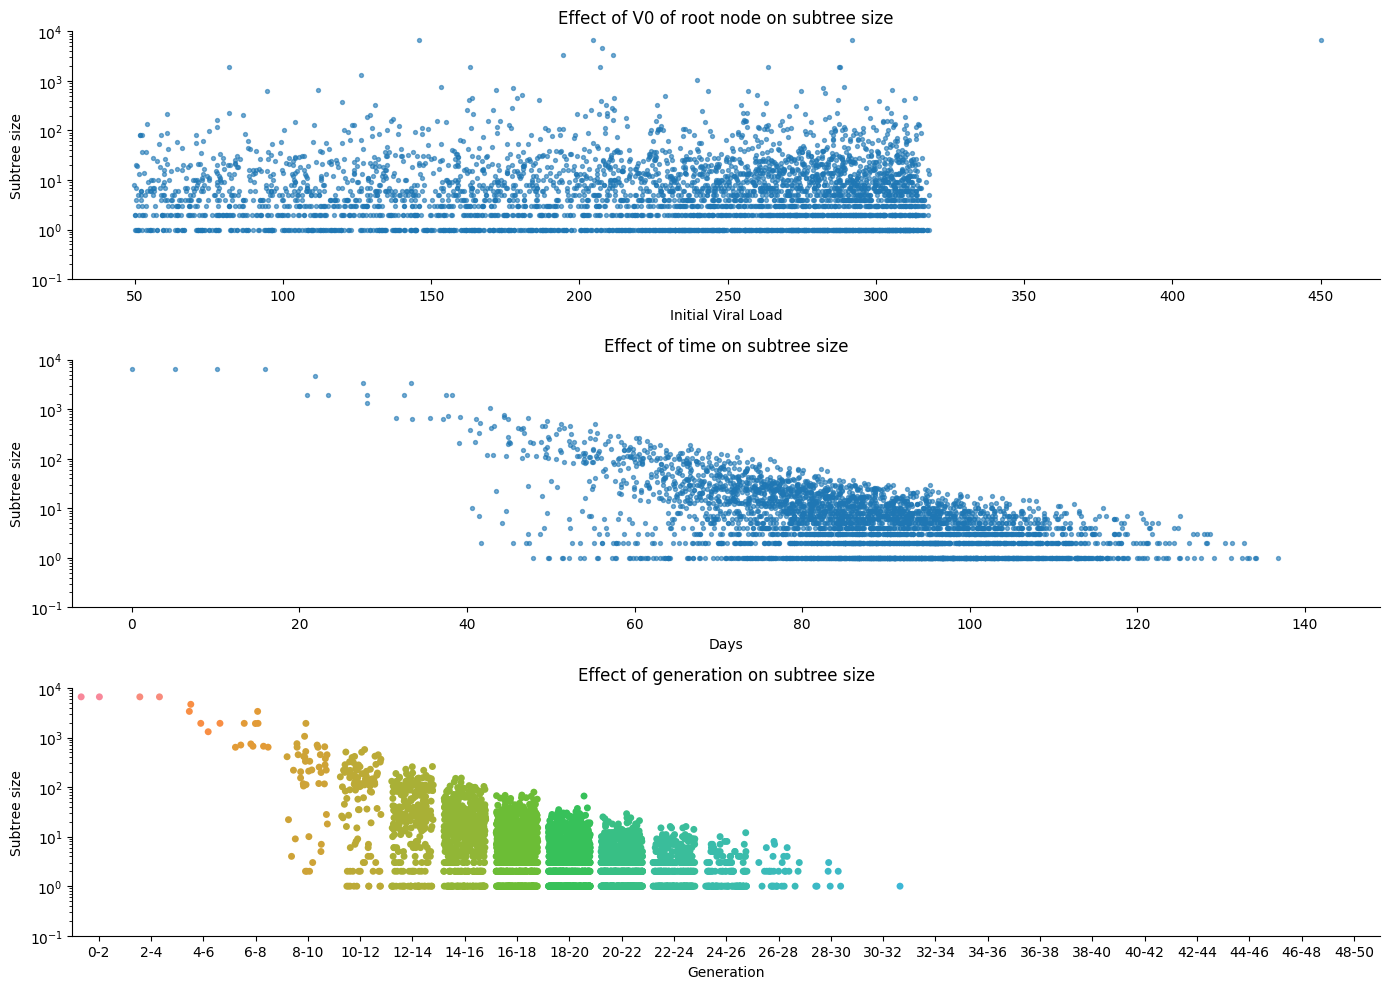

In [197]:
ptr.figure(figsize=(14,10), dpi=100)

axes_a = ptr.subplot(311, yscale='log', title='Effect of V0 of root node on subtree size', ylim=(0.1,10000))
axes_a.set_ylabel("Subtree size")
axes_a.set(xlabel="Initial Viral Load")

axes_b = ptr.subplot(312, yscale='log', title='Effect of time on subtree size', ylim=(0.1,10000))
axes_b.set_ylabel("Subtree size")
axes_b.set(xlabel="Days")

axes_c = ptr.subplot(313, yscale='log', title='Effect of generation on subtree size', ylim=(0.1,10000))
axes_c.set_ylabel("Subtree size")
axes_c.set(xlabel="Generation")

labs_vs = [str(int(bins_vs[h-1])) + '-' + str(int(bins_vs[h])) for h in range(1,len(bins_vs))]
labs_time = [str(int(bins_time[h-1])) + '-' + str(int(bins_time[h])) for h in range(1,len(bins_time))]
labs_gen = [str(int(bins_gen[h-1])) + '-' + str(int(bins_gen[h])) for h in range(1,len(bins_gen))]


axes_a.scatter(init_vs,sizes,s=8,alpha=0.6)
# sns.stripplot(data=[[h[0] for h in g] for g in binned_init_vs[1:]], ax=axes_a, jitter=0.4)
# sns.despine()

axes_b.scatter(times,sizes,s=8,alpha=0.6)
# sns.stripplot(data=[[h[0] for h in g] for g in binned_time[1:]], ax=axes_b, jitter=0.4)
# sns.despine()

sns.stripplot(data=[[h[0] for h in g] for g in binned_gen[1:]], ax=axes_c, jitter=0.4)
sns.despine()

# axes_a.set_xticklabels(labs_vs)
# axes_b.set_xticklabels(labs_time)
axes_c.set_xticklabels(labs_gen)

ptr.tight_layout()

ptr.savefig(fname='size_sp_' + j + '_' + f)
ptr.show()

ptr.close("all")

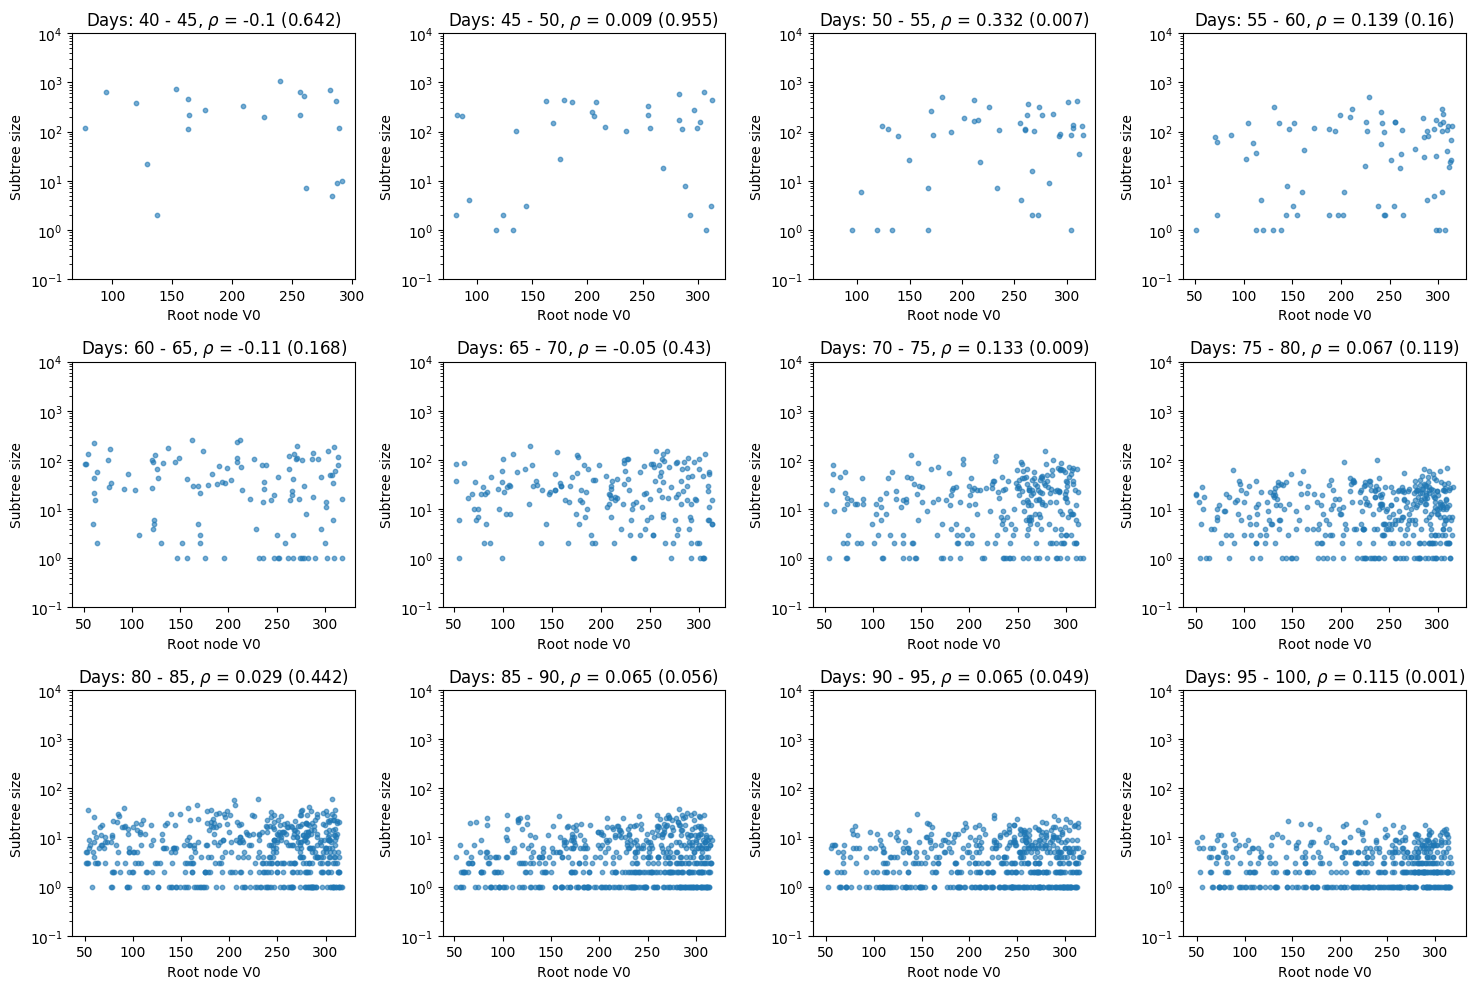

In [198]:
ptr.figure(figsize=(15,10), dpi=100)

length = 3
width = 4

size = length * width

time_min = 40
time_max = 100
j_add = (time_max-time_min) / size
i_add = width * j_add

for i in range(3):
    for h in range(4):
        init_vs = []
        sizes = []
        lengths = []
        sec_cases = []
        lower = time_min + i_add*i + j_add*h
        upper = time_min + i_add*i + j_add*(h+1)

        binned_init_vs = []
        bins_vs = np.linspace(0,500,num=11)
        for g in bins_vs:
            binned_init_vs.append([])

        for node in tree.nodes():
            if tree.nodes[node]['time'] > lower*steps_per_day and tree.nodes[node]['time'] < upper*steps_per_day:
                sub = nx.dfs_tree(tree,node)
                bin_no_vs = np.digitize(tree.nodes[node]['init_v'],bins_vs)

                init_vs.append(tree.nodes[node]['init_v'])
                sizes.append(sub.size())
                lengths.append(get_avg_length_gen(sub,node))
                sec_cases.append(len(list(tree.successors(node))))
                binned_init_vs[bin_no_vs].append([sub.size(),get_avg_length_gen(sub,node),len(list(tree.successors(node))),np.mean([tree.nodes[i]['init_v'] for i in tree.successors(node)]) / tree.nodes[node]['init_v']])

        if len(init_vs) > 2:
            spear_r = spearmanr(init_vs,sizes)
            spear_r_p = round(spear_r[1],3)
            spear_r = round(spear_r[0],3)
        else:
            pear_r = 'NaN'
            spear_r = 'NaN'
            spear_r_p = 'NaN'

        # labs_vs = [str(int(bins_vs[h-1])) + '-' + str(int(bins_vs[h])) for h in range(1,len(bins_vs))]
        labs_vs = [str(int(bins_vs[h-1])) for h in range(1,len(bins_vs))]

        ax = ptr.subplot2grid((3,4), (i,h), title='Days: ' + str(int(lower)) + ' - ' + str(int(upper)) + ', $\\rho$ = ' + str(spear_r) + ' (' + str(spear_r_p) + ')', ylabel='Subtree size', xlabel='Root node V0',ylim=(0.1,10000), yscale='log')
        # ax = ptr.subplot2grid((3,4), (i,h), title='Time (days) range: ' + str(int(lower)) + ' - ' + str(int(upper)) + ', r = ' + str(pear_r), ylabel='Mean path length', xlabel='Root node V0', xlim=(0,500),ylim=(-1,15))
        # ax = ptr.subplot2grid((3,4), (i,h), title='Time (days) range: ' + str(int(lower)) + ' - ' + str(int(upper)) + ', r = ' + str(pear_r), ylabel='Secondary cases', xlabel='Root node V0', xlim=(0,500),ylim=(-1,15))
        ax.scatter(init_vs,sizes, s=10,alpha=0.6)
        # ax.boxplot([[h[0] for h in g] for g in binned_init_vs[1:]], labels=labs_vs)
#         sns.stripplot(data=[[h[0] for h in g] for g in binned_init_vs[1:]], ax=ax, jitter=0.4)
#         ax.set_xticklabels(labs_vs)
#         ptr.xticks(fontsize=8)


ptr.tight_layout()

ptr.savefig(fname='binned_size_sp_' + j + '_' + f)
ptr.show()

ptr.close("all")

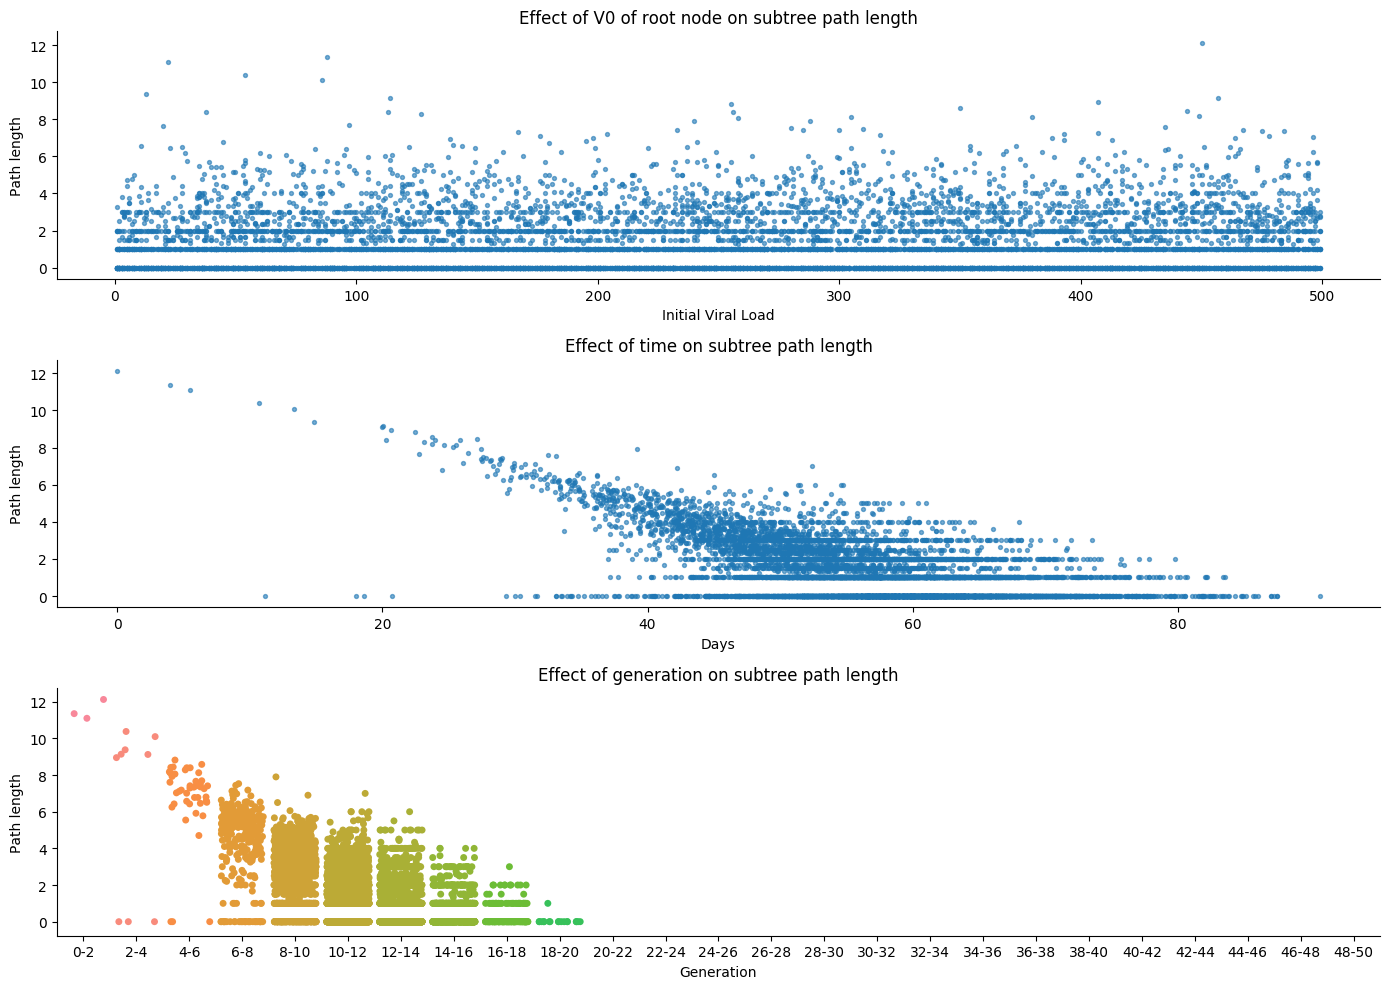

In [180]:
ptr.figure(figsize=(14,10), dpi=100)

axes_a = ptr.subplot(311, title='Effect of V0 of root node on subtree path length')
axes_a.set_ylabel("Path length")
axes_a.set(xlabel="Initial Viral Load")

axes_b = ptr.subplot(312, title='Effect of time on subtree path length')
axes_b.set_ylabel("Path length")
axes_b.set(xlabel="Days")

axes_c = ptr.subplot(313, title='Effect of generation on subtree path length')
axes_c.set_ylabel("Path length")
axes_c.set(xlabel="Generation")

labs_vs = [str(int(bins_vs[h-1])) + '-' + str(int(bins_vs[h])) for h in range(1,len(bins_vs))]
labs_time = [str(int(bins_time[h-1])) + '-' + str(int(bins_time[h])) for h in range(1,len(bins_time))]
labs_gen = [str(int(bins_gen[h-1])) + '-' + str(int(bins_gen[h])) for h in range(1,len(bins_gen))]

axes_a.scatter(init_vs,lengths,s=8,alpha=0.6)
# sns.stripplot(data=[[h[1] for h in g] for g in binned_init_vs[1:]], ax=axes_a, jitter=0.4)
# sns.despine()

axes_b.scatter(times,lengths,s=8,alpha=0.6)
# sns.stripplot(data=[[h[1] for h in g] for g in binned_time[1:]], ax=axes_b, jitter=0.4)
# sns.despine()

sns.stripplot(data=[[h[1] for h in g] for g in binned_gen[1:]], ax=axes_c, jitter=0.4)
sns.despine()

# axes_a.set_xticklabels(labs_vs)
# axes_b.set_xticklabels(labs_time)
axes_c.set_xticklabels(labs_gen)

ptr.tight_layout()

ptr.savefig(fname='len_gen_sp_' + j + '_' + f)
ptr.show()

ptr.close("all")

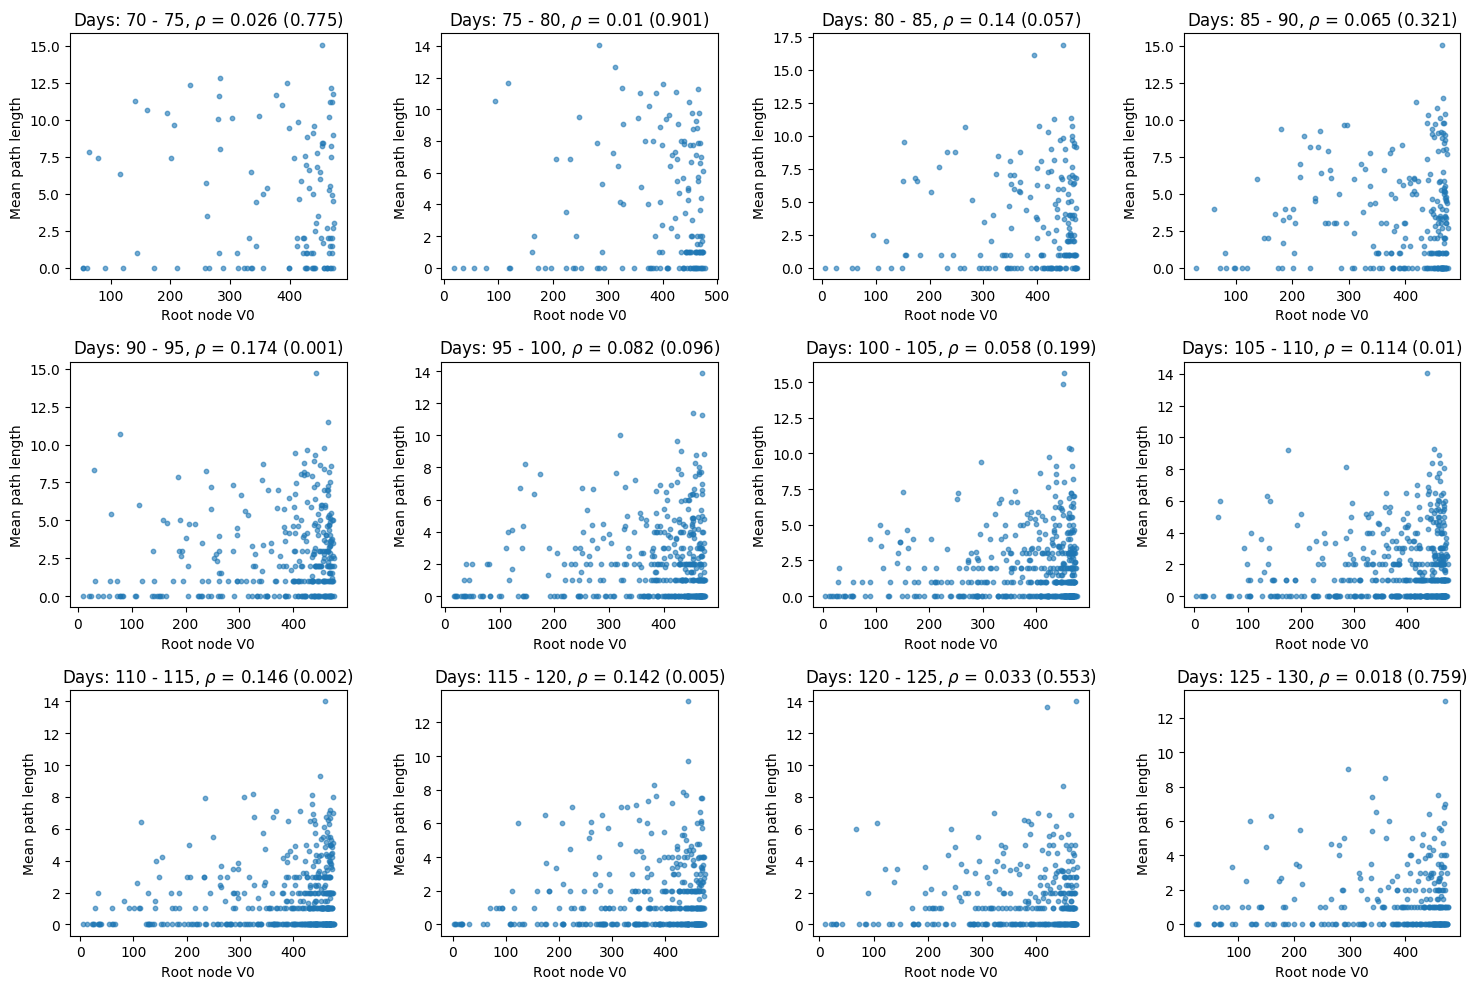

In [76]:
ptr.figure(figsize=(15,10), dpi=100)

length = 3
width = 4

size = length * width

time_min = 70
time_max = 130
j_add = (time_max-time_min) / size
i_add = width * j_add

for i in range(3):
    for h in range(4):
        init_vs = []
        sizes = []
        lengths = []
        sec_cases = []
        lower = time_min + i_add*i + j_add*h
        upper = time_min + i_add*i + j_add*(h+1)

        binned_init_vs = []
        bins_vs = np.linspace(0,500,num=11)
        for g in bins_vs:
            binned_init_vs.append([])

        for node in tree.nodes():
            if tree.nodes[node]['time'] > lower*steps_per_day and tree.nodes[node]['time'] < upper*steps_per_day:
                sub = nx.dfs_tree(tree,node)
                bin_no_vs = np.digitize(tree.nodes[node]['init_v'],bins_vs)

                init_vs.append(tree.nodes[node]['init_v'])
                sizes.append(sub.size())
                lengths.append(get_avg_length_gen(sub,node))
                sec_cases.append(len(list(tree.successors(node))))
                binned_init_vs[bin_no_vs].append([sub.size(),get_avg_length_gen(sub,node),len(list(tree.successors(node))),np.mean([tree.nodes[i]['init_v'] for i in tree.successors(node)]) / tree.nodes[node]['init_v']])

        if len(init_vs) > 2:
            spear_r = spearmanr(init_vs,sizes)
            spear_r_p = round(spear_r[1],3)
            spear_r = round(spear_r[0],3)
        else:
            pear_r = 'NaN'
            spear_r = 'NaN'
            spear_r_p = 'NaN'

        # labs_vs = [str(int(bins_vs[h-1])) + '-' + str(int(bins_vs[h])) for h in range(1,len(bins_vs))]
        labs_vs = [str(int(bins_vs[h-1])) for h in range(1,len(bins_vs))]

        ax = ptr.subplot2grid((3,4), (i,h), title='Days: ' + str(int(lower)) + ' - ' + str(int(upper)) + ', $\\rho$ = ' + str(spear_r) + ' (' + str(spear_r_p) + ')', ylabel='Mean path length', xlabel='Root node V0')
        # ax = ptr.subplot2grid((3,4), (i,h), title='Time (days) range: ' + str(int(lower)) + ' - ' + str(int(upper)) + ', r = ' + str(pear_r), ylabel='Mean path length', xlabel='Root node V0', xlim=(0,500),ylim=(-1,15))
        # ax = ptr.subplot2grid((3,4), (i,h), title='Time (days) range: ' + str(int(lower)) + ' - ' + str(int(upper)) + ', r = ' + str(pear_r), ylabel='Secondary cases', xlabel='Root node V0', xlim=(0,500),ylim=(-1,15))
        ax.scatter(init_vs,lengths, s=10,alpha=0.6)
        # ax.boxplot([[h[0] for h in g] for g in binned_init_vs[1:]], labels=labs_vs)
#         sns.stripplot(data=[[h[0] for h in g] for g in binned_init_vs[1:]], ax=ax, jitter=0.4)
#         ax.set_xticklabels(labs_vs)
#         ptr.xticks(fontsize=8)


ptr.tight_layout()

ptr.savefig(fname='binned_len_sp_' + j + '_' + f)
ptr.show()

ptr.close("all")

In [ ]:
ptr.figure(figsize=(14,10), dpi=100)

axes_a = ptr.subplot(311, title='Effect of V0 of root node on subtree path length')
axes_a.set_ylabel("Path length")
axes_a.set(xlabel="Initial Viral Load")

axes_b = ptr.subplot(312, title='Effect of time on subtree path length')
axes_b.set_ylabel("Path length")
axes_b.set(xlabel="Days")

axes_c = ptr.subplot(313, title='Effect of generation on subtree path length')
axes_c.set_ylabel("Path length")
axes_c.set(xlabel="Generation")

labs_vs = [str(int(bins_vs[h-1])) + '-' + str(int(bins_vs[h])) for h in range(1,len(bins_vs))]
labs_time = [str(int(bins_time[h-1])) + '-' + str(int(bins_time[h])) for h in range(1,len(bins_time))]
labs_gen = [str(int(bins_gen[h-1])) + '-' + str(int(bins_gen[h])) for h in range(1,len(bins_gen))]

sns.stripplot(data=[[h[5] for h in g] for g in binned_init_vs[1:]], ax=axes_a, jitter=0.4)
sns.despine()

sns.stripplot(data=[[h[5] for h in g] for g in binned_time[1:]], ax=axes_b, jitter=0.4)
sns.despine()

sns.stripplot(data=[[h[5] for h in g] for g in binned_gen[1:]], ax=axes_c, jitter=0.4)
sns.despine()

axes_a.set_xticklabels(labs_vs)
axes_b.set_xticklabels(labs_time)
axes_c.set_xticklabels(labs_gen)

ptr.tight_layout()

ptr.savefig(fname='len_time_sp_' + j + '_' + f)
ptr.show()

ptr.close("all")

In [ ]:
ptr.figure(figsize=(14,10), dpi=100)

axes_a = ptr.subplot(311, title='Effect of V0 of root node on subtree secondary cases')
axes_a.set_ylabel("Secondary Cases")
axes_a.set(xlabel="Initial Viral Load")

axes_b = ptr.subplot(312, title='Effect of time on subtree secondary cases')
axes_b.set_ylabel("Secondary Cases")
axes_b.set(xlabel="Days")

axes_c = ptr.subplot(313, title='Effect of generation on subtree secondary cases')
axes_c.set_ylabel("Secondary Cases")
axes_c.set(xlabel="Generation")

labs_vs = [str(int(bins_vs[h-1])) + '-' + str(int(bins_vs[h])) for h in range(1,len(bins_vs))]
labs_time = [str(int(bins_time[h-1])) + '-' + str(int(bins_time[h])) for h in range(1,len(bins_time))]
labs_gen = [str(int(bins_gen[h-1])) + '-' + str(int(bins_gen[h])) for h in range(1,len(bins_gen))]

sns.stripplot(data=[[h[2] for h in g] for g in binned_init_vs[1:]], ax=axes_a, jitter=0.4)  
sns.despine()

sns.stripplot(data=[[h[2] for h in g] for g in binned_time[1:]], ax=axes_b, jitter=0.4)
sns.despine()

sns.stripplot(data=[[h[2] for h in g] for g in binned_gen[1:]], ax=axes_c, jitter=0.4)
sns.despine()

axes_a.set_xticklabels(labs_vs)
axes_b.set_xticklabels(labs_time)
axes_c.set_xticklabels(labs_gen)

ptr.tight_layout()

ptr.savefig(fname='sec_cases_' + j + '_' + f)
ptr.show()

ptr.close("all")

In [ ]:
ptr.figure(figsize=(14,10), dpi=100)

length = 5
width = 4

size = length * width

v_max = 500
j_add = v_max / size
i_add = width * j_add

count = 1
for i in range(5):
    for h in range(4):
        lower = i_add*i + j_add*h
        upper = i_add*i + j_add*(h+1)

        ax = ptr.subplot2grid((5,4), (i,h), title='Donor V0 range: ' + str(int(lower)) + ' - ' + str(int(upper)), xlabel='# Secondary cases', ylim=(0,1))
        ax.hist([h[2] for h in binned_init_vs[count]],bins=range(0,11),density=True, )
        count += 1


ptr.tight_layout()

ptr.savefig(fname='sec_cases_raw_dist_' + j + '_' + f)
ptr.show()

ptr.close("all")

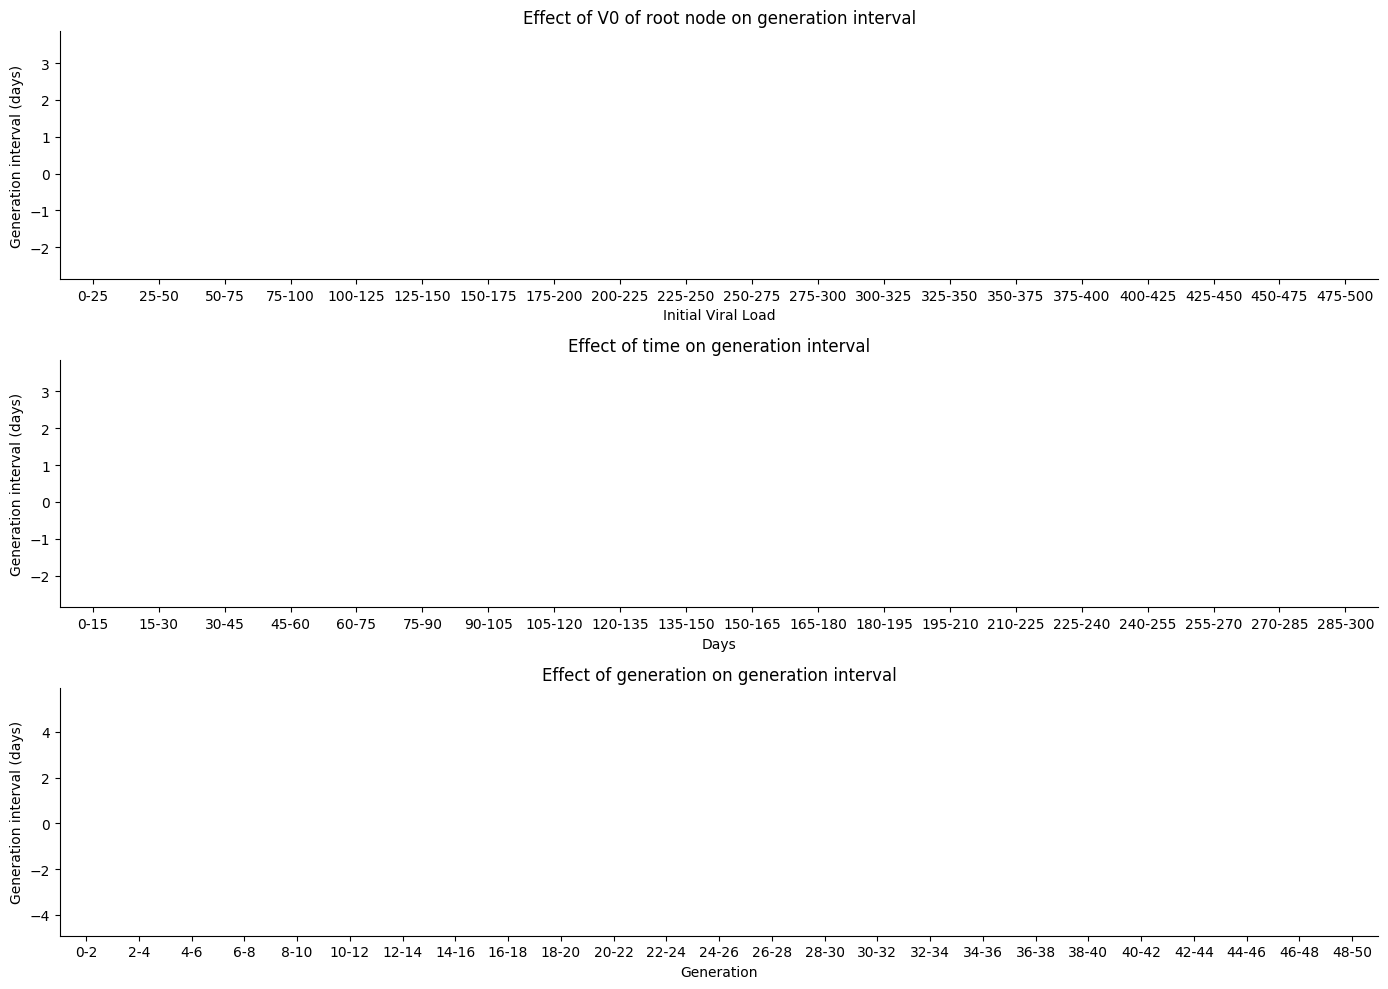

In [120]:
ptr.figure(figsize=(14,10), dpi=100)

axes_a = ptr.subplot(311, title='Effect of V0 of root node on generation interval')
axes_a.set_ylabel("Generation interval (days)")
axes_a.set(xlabel="Initial Viral Load")

axes_b = ptr.subplot(312, title='Effect of time on generation interval')
axes_b.set_ylabel("Generation interval (days)")
axes_b.set(xlabel="Days")

axes_c = ptr.subplot(313, title='Effect of generation on generation interval')
axes_c.set_ylabel("Generation interval (days)")
axes_c.set(xlabel="Generation")

labs_vs = [str(int(bins_vs[h-1])) + '-' + str(int(bins_vs[h])) for h in range(1,len(bins_vs))]
labs_time = [str(int(bins_time[h-1])) + '-' + str(int(bins_time[h])) for h in range(1,len(bins_time))]
labs_gen = [str(int(bins_gen[h-1])) + '-' + str(int(bins_gen[h])) for h in range(1,len(bins_gen))]

sns.stripplot(data=[[a for h in g for a in h[7]] for g in binned_init_vs[1:]], ax=axes_a, jitter=0.4)
sns.despine()

sns.stripplot(data=[[a for h in g for a in h[7]] for g in binned_time[1:]], ax=axes_b, jitter=0.4)
sns.despine()

sns.stripplot(data=[[a for h in g for a in h[7]] for g in binned_gen[1:]], ax=axes_c, jitter=0.4)
sns.despine()

axes_a.set_xticklabels(labs_vs)
axes_b.set_xticklabels(labs_time)
axes_c.set_xticklabels(labs_gen)

ptr.tight_layout()

ptr.savefig(fname='GI_sp_' + j + '_' + f)
ptr.show()

ptr.close("all")

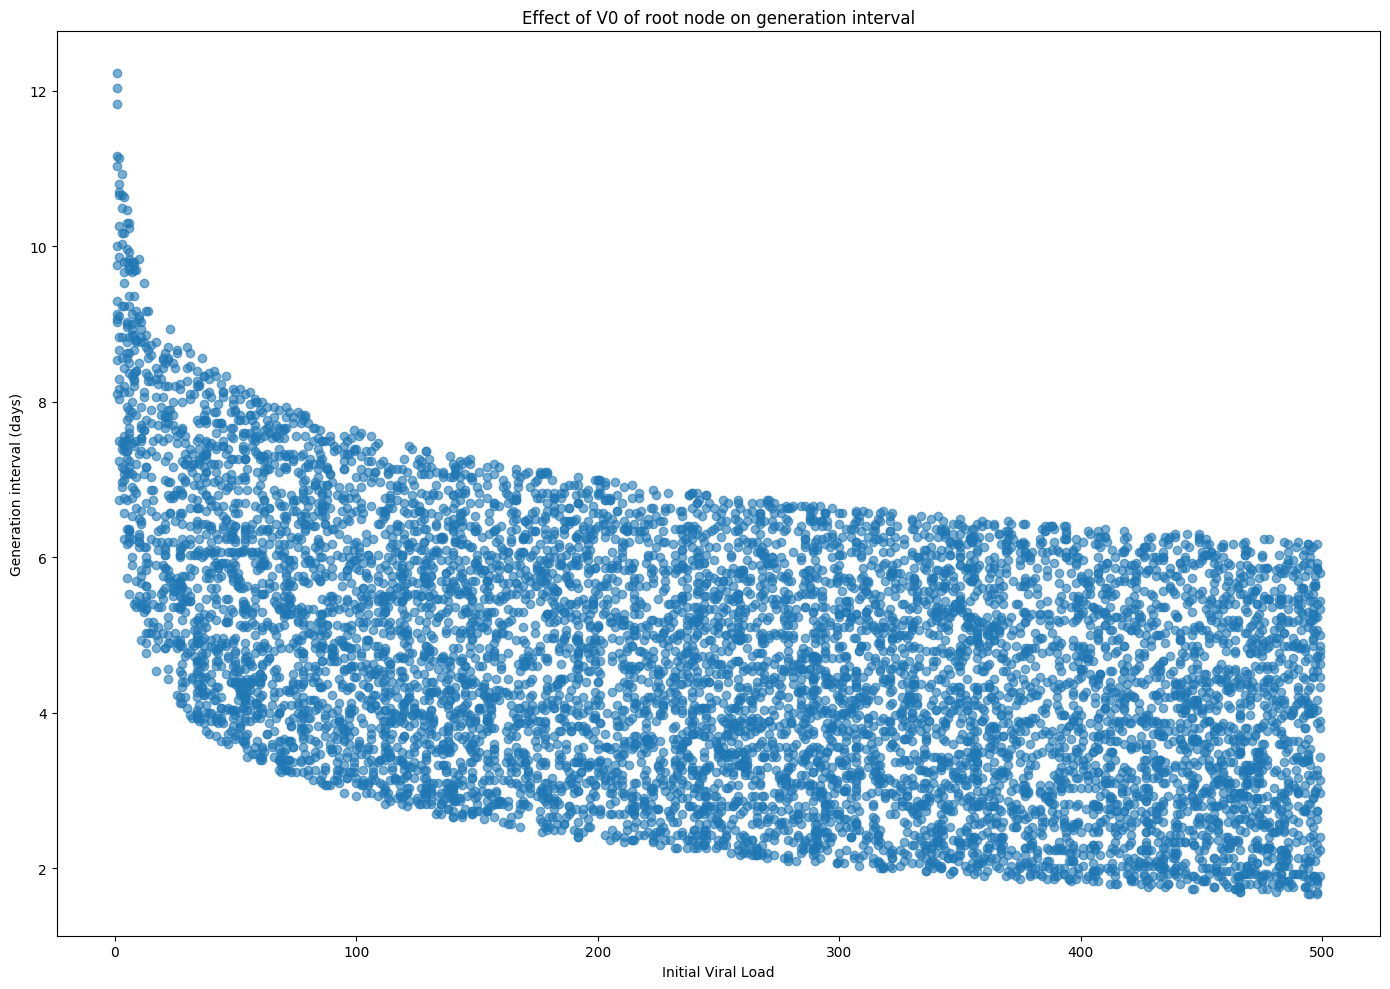

In [135]:
ptr.figure(figsize=(14,10), dpi=100)

axes_a = ptr.subplot(111, title='Effect of V0 of root node on generation interval')
axes_a.set_ylabel("Generation interval (days)")
axes_a.set(xlabel="Initial Viral Load")

# axes_b = ptr.subplot(312, title='Effect of time on generation interval')
# axes_b.set_ylabel("Generation interval (days)")
# axes_b.set(xlabel="Days")

# axes_c = ptr.subplot(313, title='Effect of generation on generation interval')
# axes_c.set_ylabel("Generation interval (days)")
# axes_c.set(xlabel="Generation")

axes_a.scatter(init_vs_parents,GIs,alpha=0.6)

# axes_b.scatter(times,GIs,alpha=0.4)

# axes_c.scatter(gens,GIs,alpha=0.4)

ptr.tight_layout()

ptr.savefig(fname='GI_scatter_' + j + '_' + f)
ptr.show()

ptr.close("all")

In [207]:
np.median([21.95, 445.06, 423.3, 242.42, 333.05, 9.25, 273.99, 462.91, 387.95, 166.09, 473.02, 145.35, 388.79, 405.45, 445.74, 468.24, 468.98, 437.21, 251.74, 280.08, 453.87, 296.85, 470.34, 463.05, 460.68, 450.29, 382.23, 294.97, 465.76, 469.97, 186.41, 464.76, 470.48, 303.5, 121.07, 385.71, 458.2, 35.63, 202.51, 446.06, 455.86, 473.04, 385.39, 258.18, 456.71, 70.64, 457.08, 194.55, 359.54, 388.93, 216.82, 467.27, 464.08, 422.74, 330.78, 464.6, 446.05, 450.22, 439.89, 259.55, 449.65, 467.81, 257.94, 363.86, 353.84, 438.11, 459.06, 460.98, 373.65, 407.65, 463.56, 470.02, 396.05, 463.69, 389.46, 36.03, 445.54, 466.95, 465.96, 447.49, 468.18, 404.95, 444.86, 366.44, 451.18, 291.16, 454.61, 235.47, 231.77, 254.33, 460.58, 453.18, 465.19, 456.6, 394.83, 470.9, 473.33, 353.26, 445.66, 277.16, 450.29, 432.3, 360.09, 322.69, 430.05, 438.71, 354.52, 417.46, 470.0, 360.93, 179.44, 116.88, 472.51, 316.99, 439.59, 378.56, 316.21, 299.68, 336.73, 367.55, 438.63, 415.36, 353.52, 293.04, 440.01, 465.75, 473.0, 429.06, 208.32, 413.62, 445.01, 425.33, 459.26, 332.22, 387.16, 402.03, 459.76, 465.84, 408.91, 470.88, 437.0, 465.39, 396.46, 160.93, 449.67, 322.42, 381.61, 455.45, 424.93, 464.54, 361.41, 410.97, 430.67, 469.77, 340.26, 449.55, 444.95, 233.11, 318.38, 389.67, 121.34, 471.52, 462.21, 235.83, 467.45, 135.94, 204.7, 462.27, 435.82, 470.31, 187.47, 105.71, 472.87, 459.01, 460.61, 17.5, 403.8, 350.51, 299.17, 374.73, 74.97, 427.45, 456.42, 290.29, 293.66, 299.88, 443.27, 340.98, 445.74, 456.45, 190.77, 442.69, 371.26, 460.85, 466.53, 456.06, 361.51, 289.83, 458.25, 450.33, 396.63, 470.71, 458.57, 442.18, 463.41, 225.75, 32.56, 115.48, 366.78, 451.54, 449.9, 432.17, 462.97, 192.21, 163.52, 442.47, 467.45, 459.9, 435.76, 468.43, 452.91, 364.63, 436.07, 425.12,
            384.43, 164.17, 470.92, 251.74, 462.4, 470.51, 455.58, 459.86, 455.79, 439.68, 218.05, 417.46, 389.61, 276.26, 406.34, 324.87, 193.63, 108.76, 8.01, 472.79, 455.83, 394.17, 451.98, 470.11, 423.03, 406.47, 440.3, 457.85, 458.68, 452.4, 400.65, 189.55, 400.16, 464.93, 320.11, 239.87, 435.97, 434.06, 443.42, 340.44, 463.7, 473.15, 467.18, 467.91, 472.17, 452.17, 474.06, 462.88, 286.31, 278.14, 424.07, 472.69, 175.43, 374.46, 473.16, 465.77, 369.64, 448.79, 68.69, 370.59, 468.9, 470.54, 372.04, 429.02, 368.61, 426.25, 389.24, 305.18, 344.46, 363.57, 473.58, 471.96, 395.66, 465.36, 463.06, 147.11, 473.61, 448.56, 369.41, 469.0, 456.91, 416.57, 441.02, 457.73, 241.59, 465.52, 431.29, 230.36, 391.12, 379.6, 464.5, 473.12, 469.67, 357.92, 378.85, 420.24, 243.27, 457.13, 445.14, 458.4, 466.29, 363.81, 388.36, 473.36, 451.29, 465.28, 439.68, 447.35, 445.14, 468.96, 263.61, 377.16, 402.54, 119.66, 471.68, 423.69, 472.29, 340.97, 412.59, 433.9, 473.82, 356.45, 292.96, 38.57, 468.63, 469.38, 424.95, 467.03, 454.07, 471.65, 468.66, 311.93, 292.95, 461.66, 361.83, 293.49, 265.98, 470.62, 468.98, 385.79, 436.37, 182.54, 264.2, 466.98, 360.85, 436.02, 467.53, 295.7, 473.26, 459.34, 293.31, 264.22, 390.95, 469.74, 391.3, 256.47, 466.79, 408.06, 115.7, 458.91, 471.35, 457.56, 334.93, 465.9,
            231.51, 424.52, 352.99, 469.84, 464.01, 471.91, 427.99, 95.55, 277.08, 465.13, 402.86, 250.98, 452.49, 457.87, 427.05, 443.69, 466.37, 382.81, 119.56, 469.29, 460.5, 92.18, 466.87, 470.37, 432.45, 455.96, 224.07, 142.75, 263.84, 174.47, 468.27, 322.19, 455.95, 349.44, 278.02, 448.01, 453.83, 440.98, 471.09, 443.72, 419.48, 474.84, 110.41, 230.46, 449.95, 454.07, 337.11, 474.94, 442.51, 189.98, 381.48, 100.87, 64.9, 13.07, 400.09, 426.99, 464.86, 456.41, 463.38, 457.21, 242.24, 136.34, 400.15, 457.69, 474.53, 440.99, 443.57, 451.46, 381.44, 365.63, 424.79, 365.82, 201.03, 412.45, 418.09, 213.58, 466.39, 365.02, 467.1, 421.88, 464.67, 470.48, 466.17, 472.34, 454.61, 427.52, 267.24, 303.87, 466.86, 421.01, 117.07, 435.14, 466.94, 275.96, 420.08, 462.56, 451.82, 474.18, 461.89, 472.66, 388.86, 447.49, 442.04, 462.86, 470.15, 475.05, 367.83, 469.86, 428.87, 96.76, 460.98, 448.99, 55.7, 463.31, 364.56, 468.9, 456.98, 281.55, 438.83, 418.36, 420.16, 463.48, 446.64, 323.11, 432.23, 389.09, 471.77, 324.89, 319.14, 391.93, 468.82, 411.14, 460.69, 469.96, 445.37, 442.26, 461.29, 469.69, 317.61, 295.04, 205.51, 343.47, 469.48, 425.1, 375.63, 7.49, 395.46, 466.59, 369.16, 465.01, 455.75, 458.91, 256.62, 443.14, 460.04, 454.93, 273.56, 409.77, 442.8, 390.48, 202.28, 398.5, 459.84, 178.1, 179.47, 450.42, 301.28, 434.01, 417.91, 364.99, 441.22, 459.19, 419.48, 411.79, 421.98, 386.39, 330.79, 472.32, 279.36, 419.69, 394.09, 264.83, 159.47, 205.56, 279.47, 425.88, 244.18, 469.52, 376.64, 69.36, 388.68, 466.97, 465.61, 375.85, 445.63, 268.51, 445.38, 443.47, 422.22, 468.34, 418.83, 421.63, 345.81, 470.12, 296.47, 410.5, 367.88, 458.57, 12.42, 279.52, 7.79, 238.03, 232.8, 162.6, 316.33, 453.0, 467.84, 416.03, 455.77, 396.99, 451.16, 450.55, 299.62, 466.07, 224.44, 342.36, 368.57, 386.56, 201.8, 466.62, 468.0, 465.45, 468.88, 451.18, 468.37, 454.08, 448.44, 147.43, 399.23, 37.3,
            459.27, 353.38, 454.72, 24.85, 455.92, 453.54, 435.67, 425.06, 333.87, 105.9, 450.51, 449.95, 277.63, 473.5, 434.69, 431.15, 473.65, 439.86, 463.7, 375.51, 462.99, 373.22, 429.93, 426.69, 314.06, 6.69, 283.97, 472.78, 208.04, 357.56, 177.86, 468.85, 469.09, 230.56, 470.7, 374.54, 457.04, 346.98, 471.65, 345.64, 467.33, 474.53, 118.44, 467.29, 427.36, 455.55, 288.66, 183.99, 338.8, 244.85, 238.08, 466.93, 466.79, 439.68, 258.26, 471.24, 430.84, 403.15, 462.87, 338.5, 443.61, 412.11, 343.21, 300.87, 384.26, 468.32, 429.02, 444.43, 460.38, 448.17, 441.07, 464.32, 447.49, 329.17, 469.03, 150.39, 450.45, 469.72, 473.61, 222.28, 241.12, 446.51, 289.94, 448.64, 468.08, 448.19, 232.68, 328.0, 406.18, 465.79, 471.28, 426.38, 459.51, 457.23, 362.36, 458.19, 177.24, 388.24, 440.77, 470.07, 371.49, 455.22, 255.43, 388.13, 394.86, 447.12, 382.29, 300.01, 19.49, 457.6, 415.59, 218.36, 464.94, 444.83, 438.22, 457.51, 402.31, 462.92, 469.4, 470.76, 461.9, 435.77, 228.42, 429.17, 436.1, 440.83, 321.56, 456.95, 457.87, 444.62, 236.3, 289.09, 450.54, 456.87, 327.26, 409.66, 464.52, 194.91, 447.45, 100.47, 204.57, 474.3, 460.52, 383.38, 465.34, 466.62, 435.16, 398.32, 461.08, 337.41, 458.27, 438.35, 426.65, 220.03, 357.76, 456.97, 447.48, 411.54, 117.39, 297.16, 320.91, 448.24, 127.09, 380.68, 444.7, 474.81, 447.61, 224.84, 465.02, 471.42, 333.11, 460.72, 378.31, 94.27, 319.4, 457.14, 73.66, 442.27, 207.97, 360.35, 415.32, 454.08, 391.88, 65.77, 459.16, 465.22, 240.7, 136.88, 450.38, 388.28, 418.96, 289.97, 357.2, 340.88, 279.37, 380.72, 468.08, 463.36, 469.75, 402.57, 471.76, 375.55, 389.54, 466.88, 366.54, 468.4, 192.08, 299.43, 466.15, 463.57,
            163.37, 341.71, 358.14, 32.19, 467.54, 460.2, 354.4, 438.41, 453.52, 435.21, 467.15, 306.19, 51.1, 296.12, 400.89, 127.27, 474.97, 386.78, 241.05, 412.36, 436.54, 373.1, 231.71, 405.54, 463.52, 406.82, 444.54, 454.18, 461.77, 465.95, 467.97, 425.02, 430.38, 437.64, 370.52, 441.8, 388.24, 464.54, 430.25, 422.67, 414.82, 432.77, 392.35, 336.49, 429.99, 445.8, 411.14, 463.35, 156.92, 360.82, 463.88, 425.53, 454.34, 398.85, 384.05, 95.56, 457.97, 328.9, 376.92, 465.07, 428.06, 456.24, 467.73, 166.88, 376.2, 427.88, 243.0, 394.67, 419.32, 260.44, 465.9, 465.82, 384.46, 444.44, 218.89, 406.35, 404.92, 434.18, 263.51, 418.99, 449.02, 418.11, 473.98, 308.78, 386.41, 389.19, 253.8, 440.63, 439.48, 195.26, 367.58, 301.94, 391.06, 418.47, 453.02, 470.05, 470.3, 135.16, 462.23, 460.62, 219.47, 474.97, 426.61, 465.5, 384.46, 430.57, 366.04, 267.08, 23.88, 452.6, 467.98, 470.8, 459.13, 231.34, 461.0, 422.14, 215.95, 434.34, 360.94, 300.72, 462.57, 458.09, 293.04, 115.48, 446.4, 443.22, 457.39, 454.65, 416.64, 468.13, 349.49, 445.9, 301.89, 460.5, 51.55, 410.27, 459.59, 473.15, 348.56, 462.85, 422.76, 426.31, 471.25, 416.81, 459.46, 469.37, 470.48, 429.07, 400.22, 458.76, 459.96, 464.9, 453.33, 378.33, 105.0, 431.11, 320.64, 470.92, 454.58, 163.22, 373.4, 423.0, 457.89, 464.55, 473.27, 467.64, 466.64, 427.19, 328.2, 465.39, 291.22, 474.02, 469.66, 249.0, 465.98, 466.86, 459.16, 387.85, 386.32, 59.28, 444.87, 109.96, 467.81, 447.44, 426.95, 455.76, 339.7, 457.53, 402.01, 360.3, 408.25, 434.81, 455.87, 462.3, 407.53, 468.0, 465.39, 463.37, 361.13, 464.9, 470.53, 378.09, 413.18, 466.7, 440.37, 400.44, 469.16, 447.72, 451.21, 361.95, 350.5, 465.65, 448.63, 455.08, 462.94, 454.65, 395.66, 452.74, 455.61, 397.64, 461.52, 450.52, 176.73, 439.86, 151.95, 454.75, 435.84, 400.5, 225.49, 463.25, 128.37, 466.27, 330.76, 358.46, 266.11, 273.51, 466.07, 441.02, 407.15,
            112.6, 404.35, 351.95, 470.4, 454.14, 353.3, 445.99, 416.09, 407.39, 467.52, 430.34, 455.73, 341.71, 472.15, 466.49, 468.8, 457.95, 307.05, 267.93, 292.69, 450.7, 357.68, 457.83, 469.7, 127.87, 472.58, 453.02, 8.61, 250.64, 350.32, 471.72, 447.54, 467.84, 366.83, 448.51, 386.02, 471.31, 377.12, 471.35, 468.22, 460.0, 459.2, 458.99, 454.95, 438.61, 470.59, 457.53, 330.07, 425.33, 452.25, 471.76, 387.93, 427.09, 357.83, 471.26, 13.6, 465.44, 421.59, 401.34, 413.83, 459.25, 440.03, 388.05, 451.45, 463.05, 464.26, 468.68, 419.42, 272.14, 473.58, 300.7, 416.27, 457.84, 154.39, 425.27, 471.41, 471.71, 407.2, 377.15, 455.56, 470.97, 40.66, 429.97, 365.06, 403.79, 412.98, 467.81, 442.99, 443.04, 404.52, 298.9, 347.77, 250.45, 447.89, 130.42, 464.57, 445.32, 436.9, 451.71, 353.92, 311.77, 377.0, 466.8, 422.09, 392.25, 441.04, 307.69, 455.33, 346.44, 467.56, 424.26, 415.74, 275.85, 358.49, 465.72, 391.04, 450.98, 466.83, 466.69, 48.18, 222.14, 85.93, 387.9, 193.59, 318.06, 455.34, 408.08, 439.29, 461.74, 306.52, 443.46, 123.59, 130.3, 374.09, 465.17, 463.04, 439.53, 115.59, 454.26, 417.4, 455.98, 460.03, 459.55, 241.21, 466.96, 351.78, 472.58, 466.52, 336.82, 439.67, 381.38, 402.71, 448.46, 472.09, 373.76, 323.53, 321.33, 421.41, 470.08, 39.01, 467.11, 440.64, 466.66, 304.72, 401.64, 29.71, 286.58, 277.89, 457.95, 439.47, 351.57, 425.0, 407.74, 432.59, 444.93, 46.1, 473.11, 412.24, 273.38, 447.28, 461.17, 257.58, 470.73, 374.36, 118.78, 434.27, 411.8])

427.485